In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import json
import math
import os
import statistics
import sys

sys.path.append(os.path.expanduser("~/GitHub/EvenTDT"))
sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from eventdt.logger import logger
from eventdt.objects.exportable import Exportable
from eventdt.queues import Queue
from eventdt.queues.consumers import algorithms
from eventdt.queues.consumers.algorithms import FUEGOConsumer
from eventdt import twitter
from eventdt.twitter import corpus

from multiplex import drawable

understanding = os.path.expanduser('~/DATA/c7-emm/data/cache/20220904-13.tar.gz')
file = os.path.expanduser('~/DATA/c7-emm/data/20220905-18/event.json')
split, track = ['member', 'remov', 'leav', 'resign'], 'patel'

In [2]:
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 9 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 13, 'markeredgewidth': 3, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'align': 'right', 'fontsize': 'smaller', 
                     'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }

faded_style = dict(style)
faded_style.update({ 'color': 'C5' })
highlight_style = dict(style)
highlight_style.update({ 'color': 'C0' })

## Understanding period

In [3]:
with open(understanding) as f:
    data = json.loads(f.readline())
    scheme = Exportable.decode(data)['scheme']
consumer = FUEGOConsumer(Queue(), scheme=scheme, window_size=600, min_volume=25,
                         threshold=algorithms.DynamicThreshold.MEAN_STDEV,
                         storage=algorithms.StorageLevel.ATTRIBUTES,
                         filtering=algorithms.FilteringLevel.LENIENT)

21:34:32: INFO: Window size:      600
21:34:32: INFO: Tracking:         90
21:34:32: INFO: Burst:            [0.5, 0.2]
21:34:32: INFO: Minimum volume:   25
21:34:32: INFO: Threshold:        DynamicThreshold.MEAN_STDEV
21:34:32: INFO: Filtering:        FilteringLevel.LENIENT
21:34:32: INFO: Reporting:        ReportingLevel.ALL
21:34:32: INFO: Storage:          StorageLevel.ATTRIBUTES
21:34:32: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (132128 documents)


## Event period

In [4]:
def volume(bin, track=None, filtered=False, *args, **kwargs):
    """
    Count the number of tweets in the given bin.

    :param bin: A bin containing a list of tweets to count.
    :type bin: list of dict
    :param track: The keyword to track.
                  These are not used in this function.
    :type track: None or str
    :param filtered: A boolean indicating whether to filter tweets using FUEGO's rules.
    :type filtered: bool

    :return: The number of tweets in the bin.
    :rtype: int
    """
    
    return len(bin) if not filtered else len(consumer._filter_tweets(bin))

with open(file) as f:
    total = corpus.aggregate(f, agg=volume, bin_size=consumer.tdt.window_size)
    f.seek(0)
    filtered = corpus.aggregate(f, agg=volume, bin_size=consumer.tdt.window_size, filtered=True)

In [5]:
documents = [ ]
with open(file) as f:
    for line in f:
        tweet = json.loads(line)
        if consumer._validate_tweet(tweet):
            document = consumer._to_documents([ tweet ])[0]
            
            # save this document as relevant if it contains any stream terms
            if any( document.dimensions[word] for word in split ):
                documents.append(document)

In [6]:
consumer = FUEGOConsumer(Queue(), scheme=scheme, window_size=600, min_volume=25,
                         threshold=algorithms.DynamicThreshold.MEAN_STDEV,
                         storage=algorithms.StorageLevel.ATTRIBUTES,
                         filtering=algorithms.FilteringLevel.LENIENT)
consumer._update_volume(documents)
volume = consumer.volume.all()

# so far, the documents are split per second, so we split them into minutes.
stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    stream[timestamp - timestamp % consumer.tdt.window_size] += tweets

21:35:38: INFO: Window size:      600
21:35:38: INFO: Tracking:         90
21:35:38: INFO: Burst:            [0.5, 0.2]
21:35:38: INFO: Minimum volume:   25
21:35:38: INFO: Threshold:        DynamicThreshold.MEAN_STDEV
21:35:38: INFO: Filtering:        FilteringLevel.LENIENT
21:35:38: INFO: Reporting:        ReportingLevel.ALL
21:35:38: INFO: Storage:          StorageLevel.ATTRIBUTES
21:35:38: INFO: Scheme:           <class 'nlp.weighting.tfidf.TFIDF'> (132128 documents)


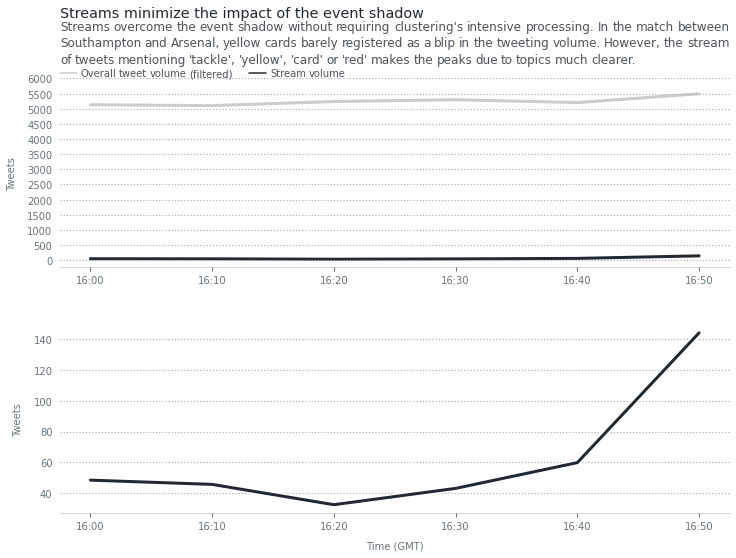

In [7]:
# prepare the data
term = '*'
timestamps = sorted(filtered.keys())
filtered_volume = [ filtered.get(timestamp, { }).get(term) for timestamp in timestamps ]
stream_volume = [ stream.get(timestamp, { }) for timestamp in timestamps ]

# set up the visualization
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# set up general settings for both plots
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 10) ]

# draw the isolated stream tweets
viz = drawable.Drawable(figure, ax2)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(stream_volume)), stream_volume, **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
# viz.set_yticks(list(range(0, math.ceil(max(stream_volume) * 1.1), 50)))
viz.set_axisbelow(True)
    
# draw the stream as a subset of all tweets
viz = drawable.Drawable(figure, ax1)
# viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(filtered_volume)), filtered_volume, f"Overall tweet volume (filtered)", **faded_style)
viz.draw_time_series(range(len(stream_volume)), stream_volume, f"Stream volume", **style)

viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_yticks(list(range(0, math.ceil(max(filtered_volume) * 1.1), 500)))

"""
Finalize the visualization.
"""
viz.set_title('Streams minimize the impact of the event shadow', loc='left')
viz.set_caption(f"""Streams overcome the event shadow without requiring clustering's intensive processing.
                    In the match between Southampton and Arsenal, yellow cards barely registered as a blip in the tweeting volume.
                    However, the stream of tweets mentioning 'tackle', 'yellow', 'card' or 'red' makes the peaks due to topics much clearer.""",
                align='justify')
viz.show()

## Breaking terms

In [8]:
consumer._update_volume(documents)
consumer._update_nutrition(documents)
nutrition = consumer.nutrition.all() # so far, the tweets are split per second
track_stream = dict.fromkeys(total.keys(), 0)
for timestamp, terms in nutrition.items():
    track_stream[timestamp - timestamp % consumer.tdt.window_size] += terms.get(track, 0)

damped_stream = dict.fromkeys(total.keys(), 0)
for timestamp, tweets in volume.items():
    damped_stream[timestamp - timestamp % consumer.tdt.window_size] += tweets

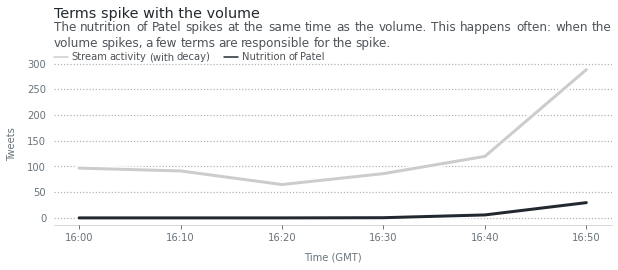

In [9]:
"""
Prepare the data.
"""
timestamps = sorted(stream.keys())
damped_stream_volume = [ damped_stream.get(timestamp, { }) for timestamp in timestamps ]
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]

"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure = plt.figure(figsize=(10,3))
viz = drawable.Drawable(figure)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Tweets')
viz.draw_time_series(range(len(damped_stream_volume)), damped_stream_volume, f"Stream activity (with decay)", **faded_style)
viz.draw_time_series(range(len(track_volume)), track_volume, f"Nutrition of { track.title() }", **style)

"""
Finalize the visualization.
"""
viz.set_title('Terms spike with the volume', loc='left')
viz.set_caption(f"""The nutrition of { track.title() } spikes at the same time as the volume.
                    This happens often: when the volume spikes, a few terms are responsible for the spike.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 10) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
# viz.set_ylim(0, math.ceil(max(damped_stream_volume) * 1.1))
# viz.set_yticks(list(range(0, math.ceil(max(stream_volume)), 25)))
viz.set_axisbelow(True)
viz.show()

In [17]:
burst_stream = {
    timestamp: consumer.tdt.detect(timestamp, min_burst=-1.1).get(track, 0)
               for timestamp in total.keys()
}

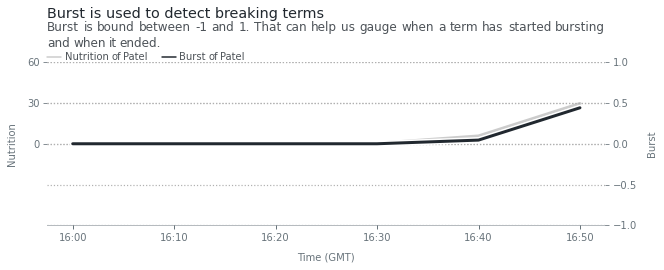

In [19]:
"""
Prepare the data.
"""
timestamps = sorted(stream.keys())
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]
burst_volume = [ burst_stream.get(timestamp) if damped_stream.get(timestamp) > consumer.min_volume else 0
                                             for timestamp in timestamps ]


"""
Draw the visualization.
"""
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, ax1 = plt.subplots(figsize=(10,3))
ax2 = ax1.twinx()

"""
Draw the nutrition visualization.
"""
viz = drawable.Drawable(figure, ax1)
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Nutrition')
viz.draw_time_series(range(len(track_volume)), track_volume, f"Nutrition of { track.title() }", **faded_style)
viz.set_ylim(-60, 60)
viz.set_yticks(list(range(0, 61, 30)))

"""
Draw the burst visualization.
"""
viz.axes = ax2
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Burst')
viz.draw_time_series(range(len(burst_volume)), burst_volume, f"Burst of { track.title() }", **style)
viz.set_ylim(-1, 1)
viz.set_yticks([ -1 + i / 2 for i in range(0, 5) ])
viz.set_axisbelow(True)

"""
Finalize the visualization.
"""
viz.set_title('Burst is used to detect breaking terms', loc='left')
viz.set_caption(f"""Burst is bound between -1 and 1.
                    That can help us gauge when a term has started bursting and when it ended.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 10) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.show()

In [23]:
burst = max(burst_volume)
timestamp = timestamps[burst_volume.index(burst)]
start = int(timestamp - 120)
bursts = {
    timestamp: consumer.tdt.detect(timestamp, min_burst=-1.1)
               for timestamp in range(start, start + 60 * 10)
}
burst_stream = {
    timestamp: bursts[timestamp].get(track, 0)
               for timestamp in range(start, start + 60 * 10)
}

In [21]:
printed = 0
for document in documents:
    if track in document.dimensions:
        print(f"{ datetime.utcfromtimestamp(document.attributes['timestamp']).strftime('%H:%M:%S') }: { document }")
        printed += 1
    
    if printed == 10:
        break

16:01:19: MP's  re WEF Interests - ATTENTION - SEVEN current and former members of the Cabinet, namely Boris Johnson, Rishi Sunak, Sajid Javid, George Osborne, Jeremy Hunt, Priti Patel, Elizabeth Truss are ALL members of the World Economic Forum!

RECOGNIZE?https://t.co/8GJ6VfiWv3
16:30:13: Apparently already 12 letters into the 1922 committee for Truss to resign, probably mostly from Johnson and Patel 😂
16:35:24: MP's  re WEF Interests - ATTENTION - SEVEN current and former members of the Cabinet, namely Boris Johnson, Rishi Sunak, Sajid Javid, George Osborne, Jeremy Hunt, Priti Patel, Elizabeth Truss are ALL members of the World Economic Forum!

RECOGNIZE?https://t.co/8GJ6VfiWv3
16:44:08: Priti Patel has resigned. https://t.co/fsJayVfGIy
16:45:05: Good, she was shit anyway.

Priti Patel resigns as home secretary https://t.co/RRY7vJGxDe
16:45:36: Translation: Priti Patel says she’ll leave the job she’s being sacked from. https://t.co/kVP5tCaav9
16:46:29: BREAK: Priti Patel quits as Ho

Detected at 16:54:49


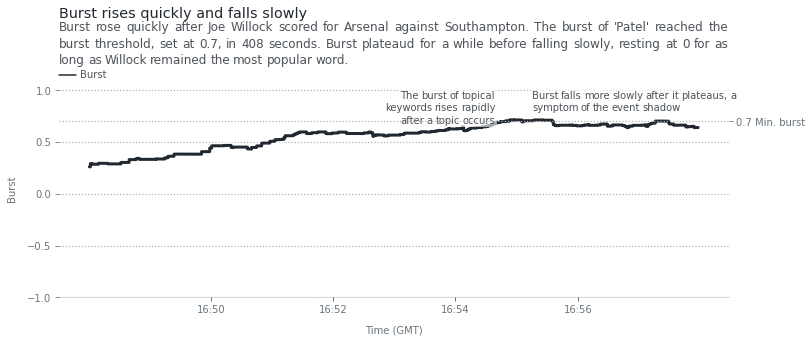

In [14]:
# prepare the data
timestamps = sorted(timestamp for timestamp in burst_stream
                              if not timestamp % 1)[1:-1]
track_volume = [ track_stream.get(timestamp) for timestamp in timestamps ]
burst_volume = [ burst_stream.get(timestamp) for timestamp in timestamps ]
highest = [ timestamp for timestamp in timestamps if burst_stream[timestamp] == 1 ]
threshold = 0.7
non_zero = [ timestamp for timestamp in timestamps if burst_stream[timestamp] > 0 ]
above_threshold = [ timestamp for timestamp in timestamps if burst_stream[timestamp] >= threshold ]
below_threshold = [ timestamps[i] for i in range(1, len(timestamps))
                                  if timestamps[i] > above_threshold[0] and burst_volume[i] < threshold ]
print(f"Detected at { datetime.utcfromtimestamp(above_threshold[0]).strftime('%H:%M:%S') }")

# prepare the annotations
annotations = {
    timestamps.index(min(above_threshold)): {
        'text': 'The burst of topical keywords rises rapidly after a topic occurs',
        'style': { 'align': 'right' }
    },
    timestamps.index(min(below_threshold)): {
        'text': 'Burst falls more slowly after it plateaus, a symptom of the event shadow',
        'style': { 'align': 'left' }
    }
}

# set up the visualization.
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, ax1 = plt.subplots(figsize=(12,4))
viz = drawable.Drawable(figure, ax1)

# draw the burst visualization
viz.set_xlabel('Time (GMT)')
viz.set_ylabel('Burst')
viz.draw_time_series(range(len(burst_volume)), burst_volume, f"Burst",
                     drawstyle='steps-post', **style)
viz.fill_between(range(len(burst_volume)), burst_volume, threshold,
                 where=[ _volume > threshold for _volume in burst_volume ],
                 interpolate=True, hatch='////', color='C1', alpha=1, linewidth=0, edgecolor='C4')
viz.set_ylim(-1, 1.1)
viz.set_yticks([ -1 + i / 2 for i in range(0, 5) ])

# describe the burst's phases
_annotation_style = dict(annotation_style)
_annotation_style.update({ 'pad': 0, 'va': 'top', 'zorder': 99 })
for x, annotation in annotations.items():
    text, _style = annotation['text'], annotation['style']
    _astyle = dict(_annotation_style)
    _astyle.update(_style)
    _x = (x - 120, x-10) if _astyle['align'] == 'right' else (x + 10, x + 250)
#     viz.axvline(x, **line_style)
    viz.annotate(text, _x, 1, **_astyle)

# show the threshold on the right
ax2 = ax1.twinx()
ax2.set_ylim(*ax1.get_ylim())
ax2.set_yticks([ threshold ])
ax2.set_yticklabels([ f"{ threshold } Min. burst" ])
ax2.set_frame_on(False)

# finalize the visualization
viz.set_title('Burst rises quickly and falls slowly', loc='left')
viz.set_caption(f"""Burst rose quickly after Joe Willock scored for Arsenal against Southampton.
                    The burst of '{ track.title() }' reached the burst threshold, set at { threshold }, in { min(above_threshold) - min(non_zero) } seconds.
                    Burst plateaud for a while before falling slowly, resting at 0 for as long as Willock remained the most popular word.""",
                align='justify')
xticks = [ i for i, timestamp in enumerate(timestamps) if not timestamp % (60 * 2) ]
viz.set_xticks(xticks)
viz.set_xticklabels([ datetime.utcfromtimestamp(timestamps[x]).strftime('%H:%M') for x in xticks ])
viz.set_axisbelow(True)
viz.show()